In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

# ### just hacking in OSD+QSS for now
# import sys
# sys.path.append('/Users/bennetmeyers/Documents/Boyd-work/optimal-signal-demixing/')
# sys.path.append('/Users/bennetmeyers/Documents/github/qss/')
# ###

from gfosd import Problem 
import gfosd.components as comp

# Testing SumCard behavior with synthetic data and missing values

## Basic changepoint detection

In [2]:
def make_basic_changepoint_data():
    true = np.ones(1000) * 12
    true[400:] -= 1.5
    msk = np.logical_and(np.arange(1000) > 600, (np.arange(1000) // 100) % 2 == 0)
    true[msk] += 1
    msk = np.logical_and(np.arange(1000) > 750, (np.arange(1000) // 100) % 2 == 0)
    true[msk] += 1
    noise = np.random.randn(1000) * .15
    y = true + noise
    return y, np.c_[noise, true].T

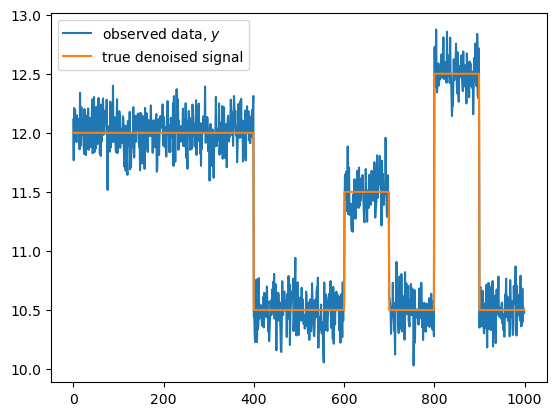

In [3]:
bcd_y, bcd_X_real = make_basic_changepoint_data()
plt.plot(bcd_y, label='observed data, $y$')
plt.plot(bcd_X_real[1], label='true denoised signal')
plt.legend()
plt.show()

### Data with random missing data

In [4]:
indices_full = list(range(len(bcd_X_real[1])))
# select 20% randomly
indices_20perc = np.random.choice(indices_full, 200, replace=False)

bcd_X_real_80perc = bcd_X_real.copy()
bcd_y_80perc = bcd_y.copy()
for e in indices_20perc:
    bcd_X_real_80perc[0][e] = np.nan
    bcd_X_real_80perc[1][e] = np.nan
    bcd_y_80perc[e] = np.nan

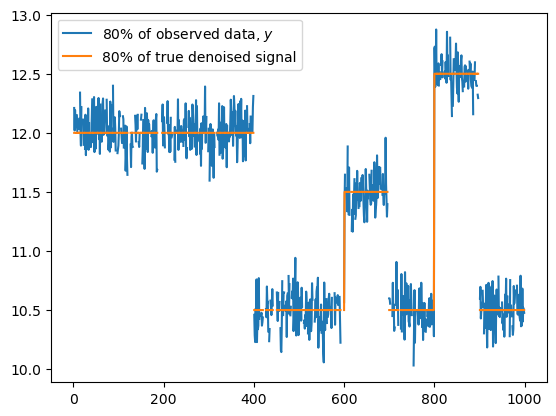

In [5]:
plt.plot(bcd_y_80perc, label='80% of observed data, $y$')
plt.plot(bcd_X_real_80perc[1], label='80% of true denoised signal')
plt.legend()
plt.show()

### Data with chunks of missing data

In [6]:
indices_chunks_start = np.random.choice(indices_full, 5, replace=False)
bcd_X_real_chunks= bcd_X_real.copy()
bcd_y_chunks = bcd_y.copy()

for e in indices_chunks_start:
    for i in range(e, e+25):
        bcd_X_real_chunks[0][i] = np.nan
        bcd_X_real_chunks[1][i] = np.nan
        bcd_y_chunks[i] = np.nan

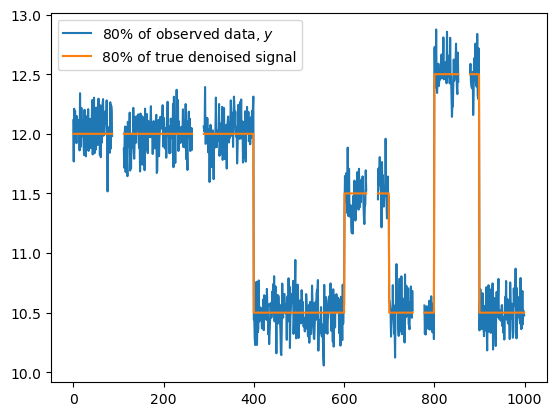

In [7]:
plt.plot(bcd_y_chunks, label='80% of observed data, $y$')
plt.plot(bcd_X_real_chunks[1], label='80% of true denoised signal')
plt.legend()
plt.show()

## Solve with full signal

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      4.25e-03s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 3.17e+01    5.15e+00     6.56e-01   [0.1 0.1]  6.95e-04
   25 | 1.15e+01    9.97e-03     3.22e-03   [0.1 0.1]  1.46e-02
   50 | 1.33e+00    5.07e-02     3.96e-03   [1.e-01 1.e-06]  3.07e-02
   75 | 1.85e-02    7.44e-04     7.54e-04   [1.e-01 1.e-06]  4.41e-02
  100 | 1.85e-02    6.02e-05     1.74e-04   [1.e-01 1.e-06]  5.79e-02
  125 | 1.84e-02    1.28e-05     1.46e-04   [1.e-01 1.e-06]  7.04e-02
  150 | 1.84e-02    7.53e-06     1.2

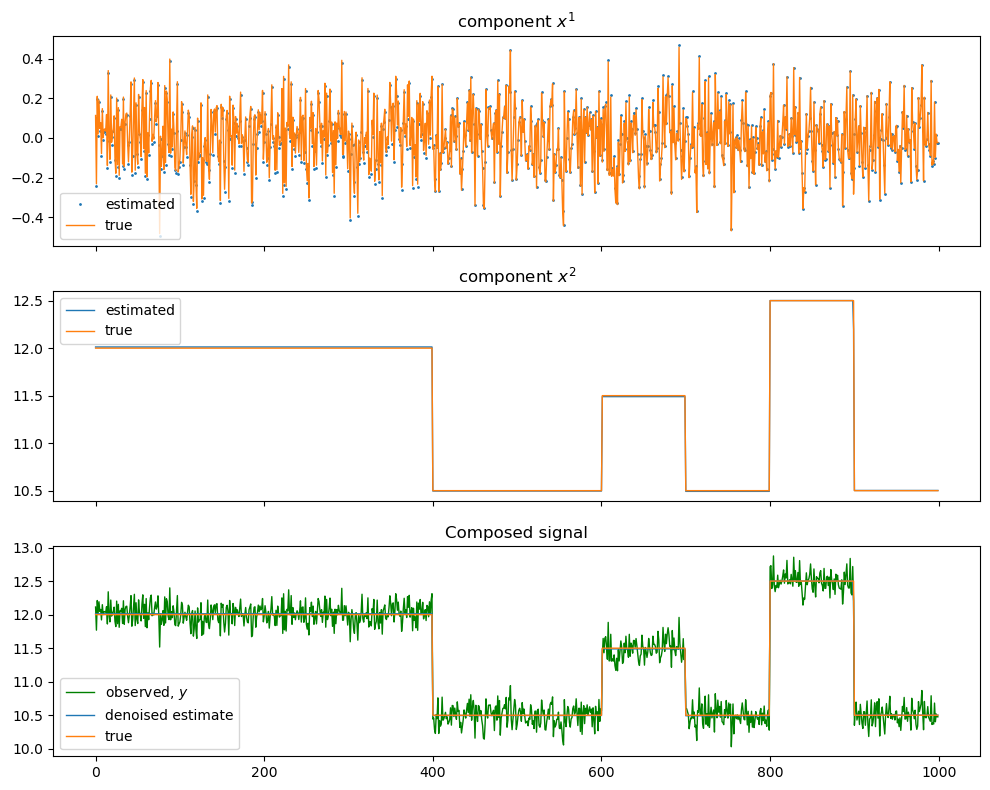

In [8]:
c1 = comp.SumSquare(weight=1/len(bcd_y))
c2 = comp.SumCard(weight=1e-3, diff=1)
bcd_problem = Problem(bcd_y, [c1, c2])
bcd_problem.decompose(verbose=True)

bcd_problem.plot_decomposition(X_real=bcd_X_real);

In [9]:
gf_full = bcd_problem.make_graph_form()
gf_full

{'P': <2999x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 1000 stored elements in COOrdinate format>,
 'q': array([0., 0., 0., ..., 0., 0., 0.]),
 'r': 0,
 'A': <1999x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 4997 stored elements in COOrdinate format>,
 'b': array([ 0.        ,  0.        ,  0.        , ..., 10.51923623,
        10.47625911, 10.47686592]),
 'g': [{'g': 'card', 'args': {'weight': 0.001}, 'range': (2000, 2999)}]}

## Signal with random missing values

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      3.46e-03s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 2.93e+01    5.15e+00     7.88e-01   [0.1 0.1]  6.42e-04
   25 | 1.12e+01    2.86e-02     4.00e-03   [0.1 0.1]  1.30e-02
   50 | 1.82e+00    1.17e-01     1.43e-02   [1.e-01 1.e-06]  2.83e-02
   75 | 5.35e-01    4.50e-02     7.15e-04   [1.e-01 1.e-06]  4.14e-02
  100 | 5.10e-01    1.53e-01     1.68e-03   [1.e-01 1.e-06]  5.45e-02
  125 | 4.75e-01    2.39e-01     1.42e-02   [1.e-01 1.e-06]  6.69e-02
  150 | 4.46e-01    2.37e-01     5.1

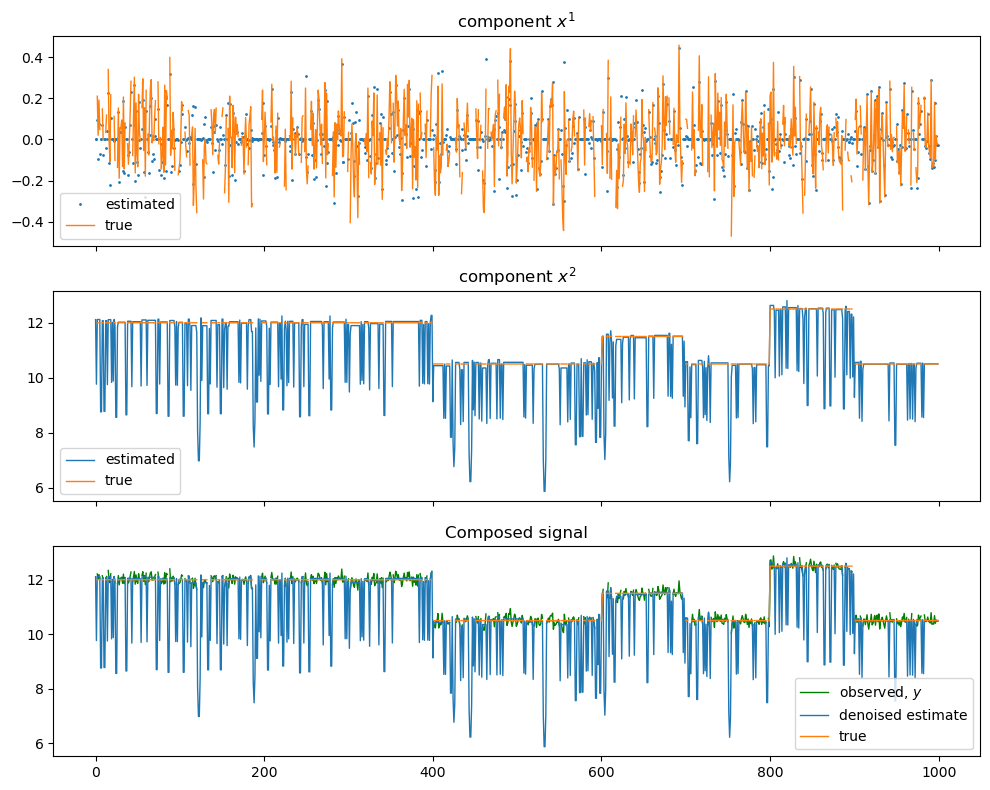

In [10]:
bcd_problem = Problem(bcd_y_80perc, [c1, c2])
bcd_problem.decompose(verbose=True)

bcd_problem.plot_decomposition(X_real=bcd_X_real_80perc);

In [11]:
gf_80perc = bcd_problem.make_graph_form()
gf_80perc

{'P': <2999x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 1000 stored elements in COOrdinate format>,
 'q': array([0., 0., 0., ..., 0., 0., 0.]),
 'r': 0,
 'A': <1799x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 4597 stored elements in COOrdinate format>,
 'b': array([ 0.        ,  0.        ,  0.        , ..., 10.51923623,
        10.47625911, 10.47686592]),
 'g': [{'g': 'card', 'args': {'weight': 0.001}, 'range': (2000, 2999)}]}

## Signal with chunks of missing values

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      3.61e-03s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 2.78e+01    5.15e+00     7.35e-01   [0.1 0.1]  6.65e-04
   25 | 1.02e+01    1.46e-02     3.25e-03   [0.1 0.1]  1.34e-02
   50 | 1.22e+00    1.39e-01     1.53e-02   [1.e-01 1.e-06]  2.89e-02
   75 | 6.91e-02    4.76e-02     7.20e-04   [1.e-01 1.e-06]  4.14e-02
  100 | 6.81e-02    5.32e-05     5.24e-04   [1.e-01 1.e-06]  5.49e-02
  125 | 6.75e-02    3.52e-05     3.75e-04   [1.e-01 1.e-06]  6.79e-02
  150 | 6.62e-02    5.95e-04     2.6

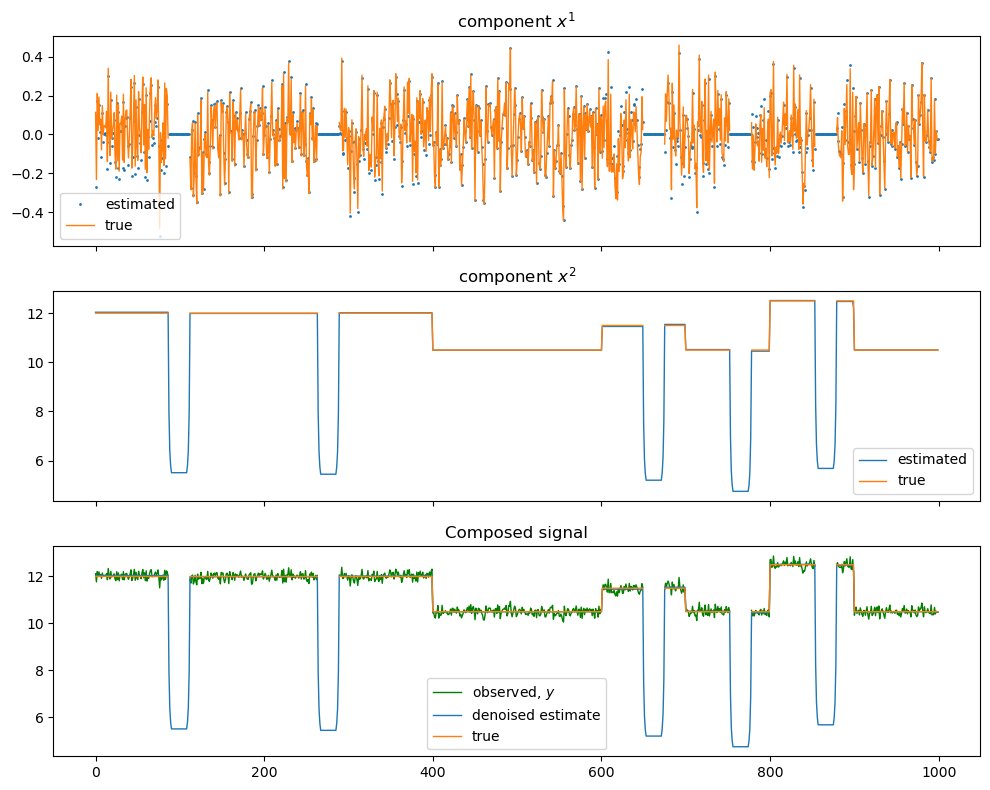

In [12]:
bcd_problem = Problem(bcd_y_chunks, [c1, c2])
bcd_problem.decompose(verbose=True)

bcd_problem.plot_decomposition(X_real=bcd_X_real_chunks);

In [13]:
gf_chunks = bcd_problem.make_graph_form()
gf_chunks

{'P': <2999x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 1000 stored elements in COOrdinate format>,
 'q': array([0., 0., 0., ..., 0., 0., 0.]),
 'r': 0,
 'A': <1874x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 4747 stored elements in COOrdinate format>,
 'b': array([ 0.        ,  0.        ,  0.        , ..., 10.51923623,
        10.47625911, 10.47686592]),
 'g': [{'g': 'card', 'args': {'weight': 0.001}, 'range': (2000, 2999)}]}

# Confirming no issues with SumAbs

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      3.62e-03s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 3.17e+01    5.15e+00     6.56e-01   [0.1 0.1]  6.38e-04
   25 | 1.15e+01    2.73e-03     2.80e-03   [0.1 0.1]  1.34e-02
   50 | 1.32e+00    1.70e-02     3.83e-03   [1.e-01 1.e-06]  2.99e-02
   75 | 1.93e-02    1.53e-03     5.92e-04   [1.e-01 1.e-06]  4.36e-02
  100 | 1.91e-02    6.72e-04     3.86e-04   [1.e-01 1.e-06]  5.76e-02
  125 | 1.89e-02    1.73e-05     3.08e-04   [1.e-01 1.e-06]  6.94e-02
  150 | 1.88e-02    5.89e-06     2.6

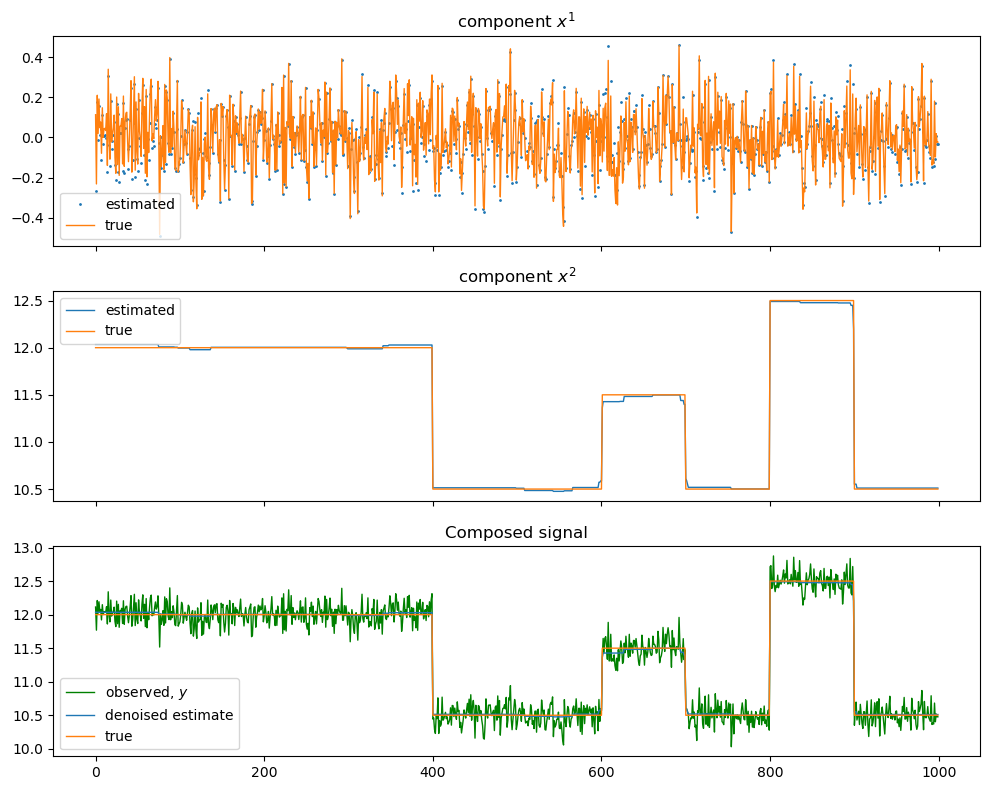

In [14]:
c1 = comp.SumSquare(weight=1/len(bcd_y))
c2 = comp.SumAbs(weight=1e-3, diff=1)
bcd_problem = Problem(bcd_y, [c1, c2])
bcd_problem.decompose(verbose=True)

bcd_problem.plot_decomposition(X_real=bcd_X_real);

In [15]:
gf_abs_full = bcd_problem.make_graph_form()
gf_abs_full

{'P': <2999x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 1000 stored elements in COOrdinate format>,
 'q': array([0., 0., 0., ..., 0., 0., 0.]),
 'r': 0,
 'A': <1999x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 4997 stored elements in COOrdinate format>,
 'b': array([ 0.        ,  0.        ,  0.        , ..., 10.51923623,
        10.47625911, 10.47686592]),
 'g': [{'g': 'abs', 'args': {'weight': 0.001}, 'range': (2000, 2999)}]}

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      3.40e-03s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 2.96e+01    5.15e+00     7.88e-01   [0.1 0.1]  6.25e-04
   25 | 1.14e+01    3.04e-03     2.79e-03   [0.1 0.1]  1.32e-02
   50 | 1.98e+00    2.00e-02     5.84e-03   [1.e-01 1.e-06]  2.78e-02
   75 | 5.26e-01    1.05e-02     1.74e-03   [1.e-01 1.e-06]  4.10e-02
  100 | 4.06e-01    1.01e-03     1.44e-03   [1.e-01 1.e-06]  5.43e-02
  125 | 2.99e-01    8.35e-03     1.22e-03   [1.e-01 1.e-06]  6.58e-02
  150 | 1.95e-01    7.89e-03     1.3

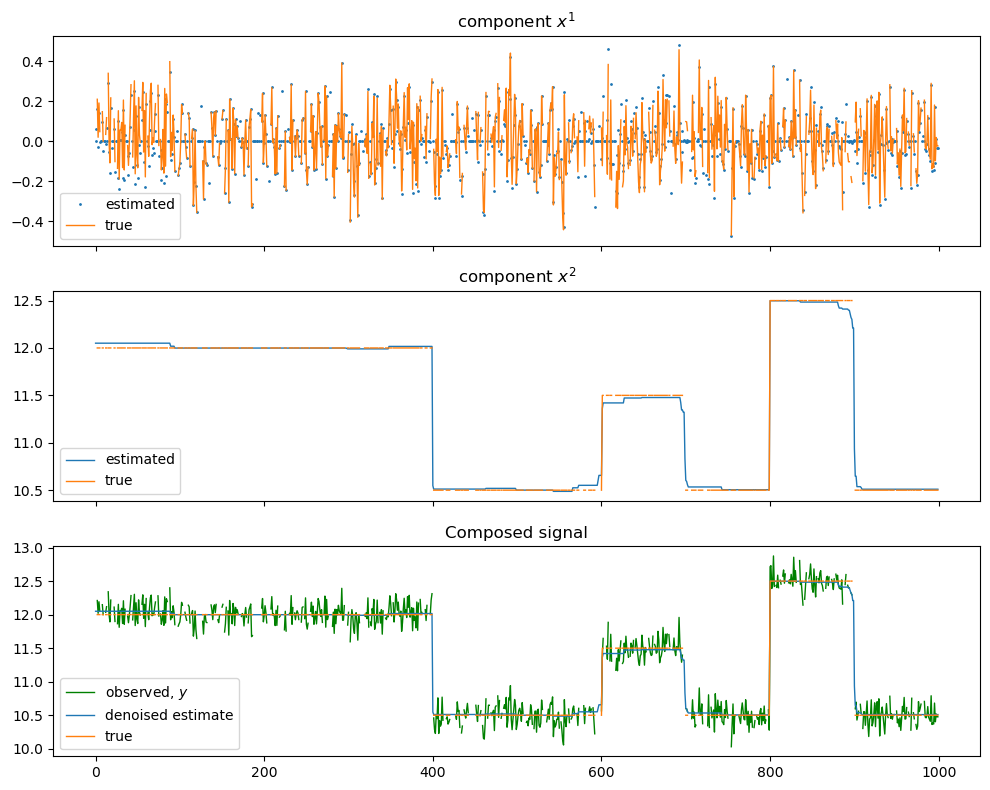

In [16]:
c1 = comp.SumSquare(weight=1/len(bcd_y))
c2 = comp.SumAbs(weight=1e-3, diff=1)
bcd_problem = Problem(bcd_y_80perc, [c1, c2])
bcd_problem.decompose(verbose=True)

bcd_problem.plot_decomposition(X_real=bcd_X_real_80perc);

In [17]:
gf_abs_80perc = bcd_problem.make_graph_form()
gf_abs_80perc

{'P': <2999x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 1000 stored elements in COOrdinate format>,
 'q': array([0., 0., 0., ..., 0., 0., 0.]),
 'r': 0,
 'A': <1799x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 4597 stored elements in COOrdinate format>,
 'b': array([ 0.        ,  0.        ,  0.        , ..., 10.51923623,
        10.47625911, 10.47686592]),
 'g': [{'g': 'abs', 'args': {'weight': 0.001}, 'range': (2000, 2999)}]}

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      4.59e-03s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 2.78e+01    5.15e+00     7.35e-01   [0.1 0.1]  8.24e-04
   25 | 1.02e+01    2.73e-03     2.80e-03   [0.1 0.1]  1.71e-02
   50 | 1.23e+00    2.00e-02     3.68e-03   [1.e-01 1.e-06]  3.20e-02
   75 | 7.12e-02    1.55e-03     1.42e-03   [1.e-01 1.e-06]  4.52e-02
  100 | 5.82e-02    2.28e-03     1.25e-03   [1.e-01 1.e-06]  5.83e-02
  125 | 5.10e-02    1.50e-04     1.01e-03   [1.e-01 1.e-06]  7.02e-02
  150 | 4.40e-02    1.97e-03     1.0

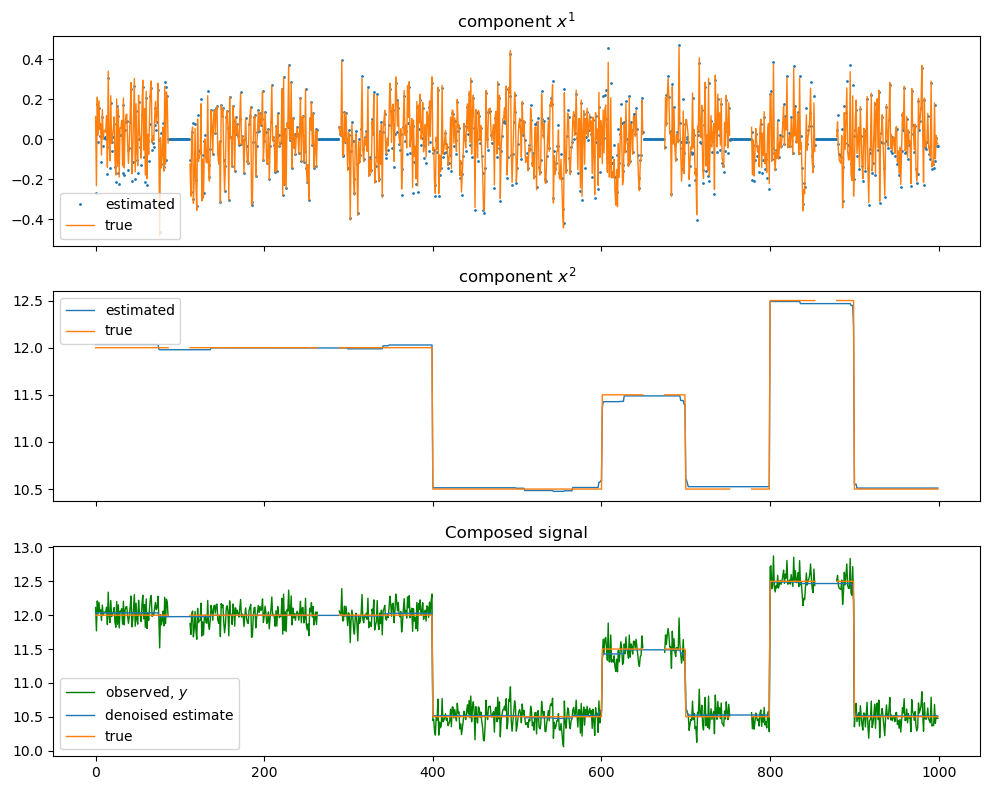

In [18]:
c1 = comp.SumSquare(weight=1/len(bcd_y))
c2 = comp.SumAbs(weight=1e-3, diff=1)
bcd_problem = Problem(bcd_y_chunks, [c1, c2])
bcd_problem.decompose(verbose=True)

bcd_problem.plot_decomposition(X_real=bcd_X_real_chunks);

In [19]:
gf_abs_chunks = bcd_problem.make_graph_form()
gf_abs_chunks

{'P': <2999x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 1000 stored elements in COOrdinate format>,
 'q': array([0., 0., 0., ..., 0., 0., 0.]),
 'r': 0,
 'A': <1874x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 4747 stored elements in COOrdinate format>,
 'b': array([ 0.        ,  0.        ,  0.        , ..., 10.51923623,
        10.47625911, 10.47686592]),
 'g': [{'g': 'abs', 'args': {'weight': 0.001}, 'range': (2000, 2999)}]}

# Compare GF

In [20]:
gf_abs_80perc # compare P, A, and b 

{'P': <2999x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 1000 stored elements in COOrdinate format>,
 'q': array([0., 0., 0., ..., 0., 0., 0.]),
 'r': 0,
 'A': <1799x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 4597 stored elements in COOrdinate format>,
 'b': array([ 0.        ,  0.        ,  0.        , ..., 10.51923623,
        10.47625911, 10.47686592]),
 'g': [{'g': 'abs', 'args': {'weight': 0.001}, 'range': (2000, 2999)}]}

In [48]:
gf_80perc # compare P, A, and b 

{'P': <2999x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 1000 stored elements in COOrdinate format>,
 'q': array([0., 0., 0., ..., 0., 0., 0.]),
 'r': 0,
 'A': <1799x2999 sparse matrix of type '<class 'numpy.float64'>'
 	with 4597 stored elements in COOrdinate format>,
 'b': array([ 0.        ,  0.        ,  0.        , ..., 10.51923623,
        10.47625911, 10.47686592]),
 'g': [{'g': 'card', 'args': {'weight': 0.001}, 'range': (2000, 2999)}]}

### P

In [47]:
scipy.sparse.find(gf_abs_80perc['P']-gf_80perc['P'])

(array([], dtype=int32), array([], dtype=int32), array([], dtype=float64))

In [45]:
scipy.sparse.find(gf_abs_full['P']-gf_full['P'])

(array([], dtype=int32), array([], dtype=int32), array([], dtype=float64))

In [46]:
scipy.sparse.find(gf_abs_chunks['P']-gf_chunks['P'])

(array([], dtype=int32), array([], dtype=int32), array([], dtype=float64))

### A

In [24]:
scipy.sparse.find(gf_abs_80perc['A']-gf_80perc['A'])

(array([], dtype=int32), array([], dtype=int32), array([], dtype=float64))

In [25]:
scipy.sparse.find(gf_abs_full['A']-gf_full['A'])

(array([], dtype=int32), array([], dtype=int32), array([], dtype=float64))

In [26]:
scipy.sparse.find(gf_abs_chunks['A']-gf_chunks['A'])

(array([], dtype=int32), array([], dtype=int32), array([], dtype=float64))

### b

In [39]:
scipy.sparse.find(gf_abs_chunks['b']-gf_chunks['b'])

(array([], dtype=int32), array([], dtype=int32), array([], dtype=float64))

In [28]:
scipy.sparse.find(gf_abs_80perc['b']-gf_80perc['b'])

(array([], dtype=int32), array([], dtype=int32), array([], dtype=float64))

In [43]:
scipy.sparse.find(gf_abs_full['b']-gf_full['b'])

(array([], dtype=int32), array([], dtype=int32), array([], dtype=float64))